<a href="https://colab.research.google.com/github/KhenissiMH/Linear_regression/blob/main/soeul_bike_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import tensorflow as tf
import seaborn as sns
from sklearn.linear_model import LinearRegression

#DataSet


In [50]:
dataset_cols=["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df=pd.read_csv("SeoulBikeData.csv").drop(["Date","Holiday", "Seasons"], axis=1)


In [51]:
df.columns=dataset_cols
df["functional"]=(df["functional"]=="Yes").astype("int")

In [52]:
df=df[df["hour"]==12]
df=df.drop("hour", axis=1)

In [6]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


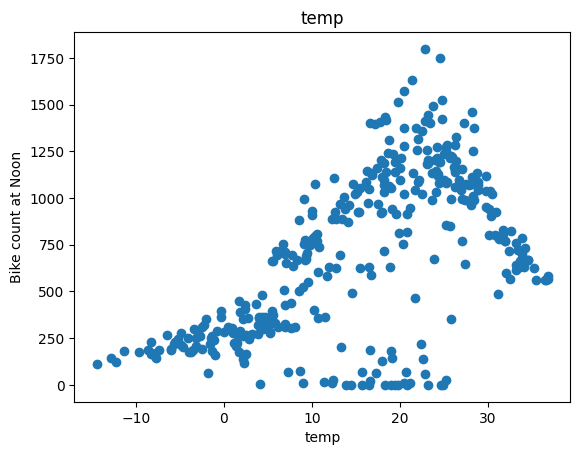

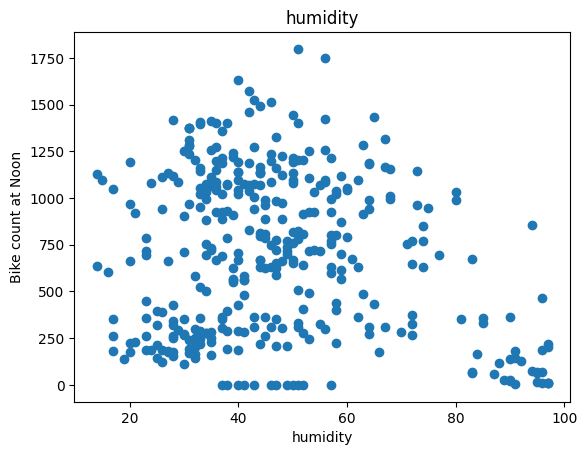

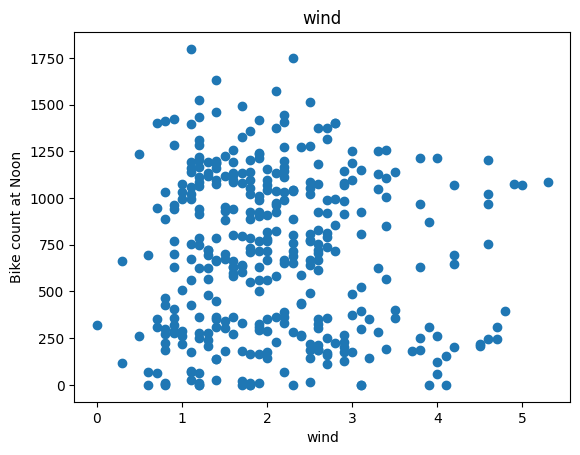

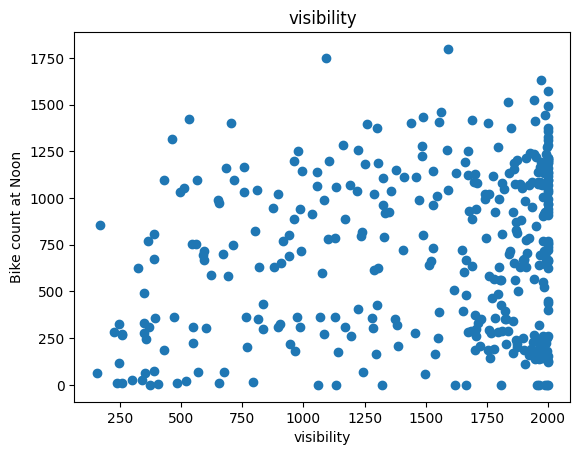

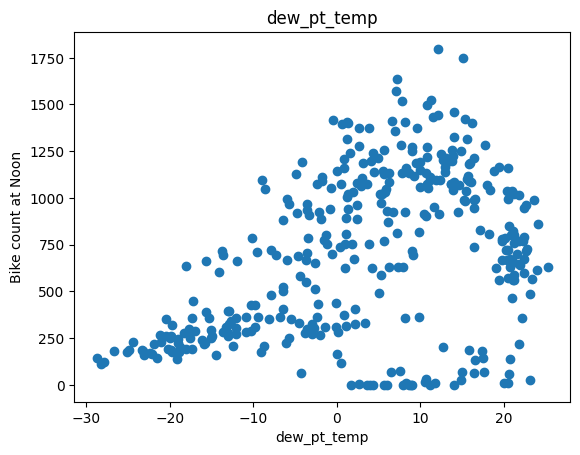

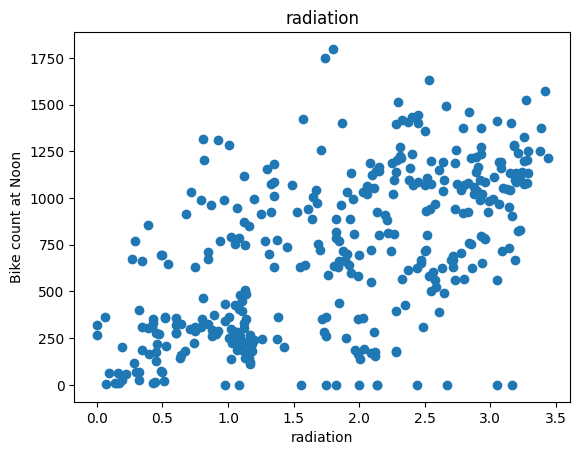

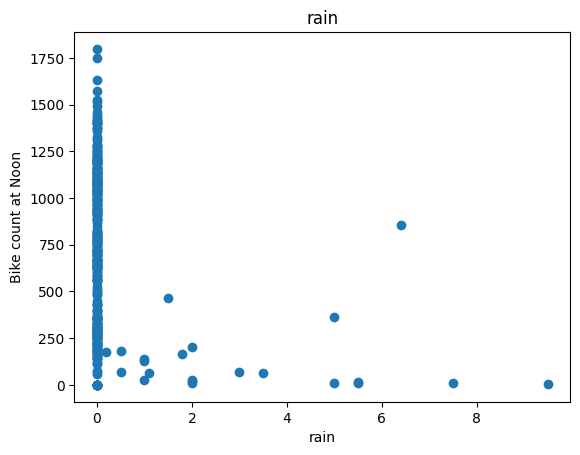

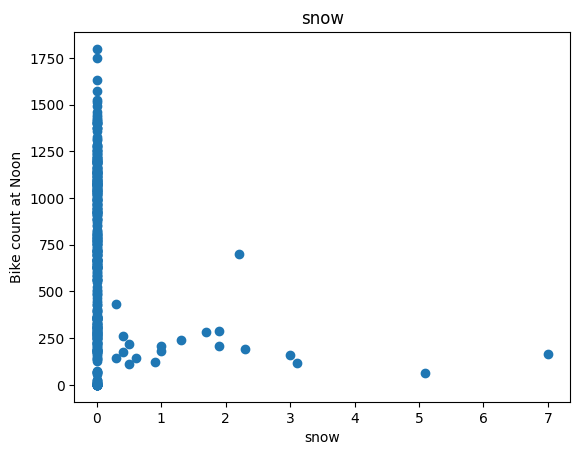

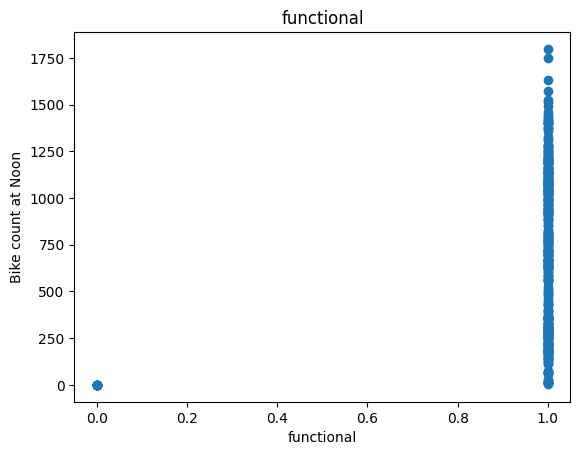

In [7]:
for label in df.columns[1:]:
  plt.scatter(df[label],df['bike_count'])
  plt.title(label)
  plt.ylabel("Bike count at Noon")
  plt.xlabel(label)
  plt.show()

In [53]:
df=df.drop(["functional", "wind", "visibility"], axis=1)

In [9]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [54]:
train, valid, test =np.split(df.sample(frac=1) , [int(0.6*len(df)) , int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [55]:
def getXY(dataframe, Y_label, X_label=None):
  dataframe=copy.deepcopy(dataframe)
  if X_label is None:
    X=dataframe[[c for c in dataframe.columns if c!=Y_label]].values
  else:
    if len(X_label) == 1:
      X=dataframe[X_label[0]].values.reshape(-1, 1)
    else:
      X=dataframe[X_label].values
  Y=dataframe[Y_label].values.reshape(-1, 1)
  data= np.hstack([X,Y])
  return data, X, Y

#Simple Linear Regression

In [56]:
_, X_train_temp, Y_train_temp=getXY(train, "bike_count", X_label=["temp"])
_, X_valid_temp, Y_valid_temp=getXY(valid, "bike_count", X_label=["temp"])
_, X_test_temp, Y_test_temp=getXY(test, "bike_count", X_label=["temp"])

In [57]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp, Y_train_temp)

LinearRegression()

In [58]:
temp_reg.score(X_test_temp, Y_test_temp)

0.24557154216002974

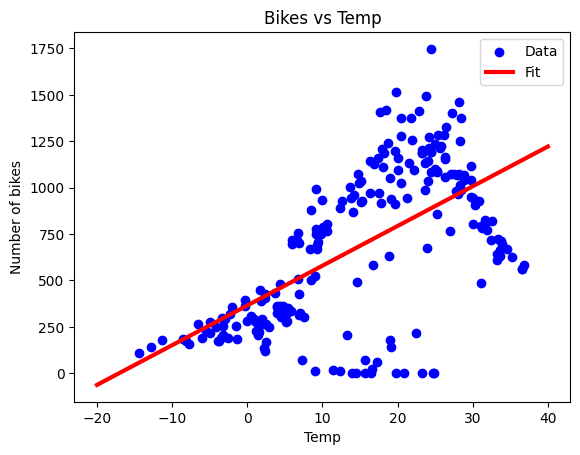

In [59]:
plt.scatter(X_train_temp, Y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)

plt.title('Bikes vs Temp')
plt.xlabel('Temp')
plt.ylabel('Number of bikes')
plt.legend()
plt.show()

#Multiple Linear Regression

In [60]:
_, X_train, Y_train=getXY(train, "bike_count", X_label = df.columns[1:])
_, X_valid, Y_valid=getXY(valid, "bike_count", X_label = df.columns[1:])
_, X_test, Y_test=getXY(test, "bike_count", X_label = df.columns[1:])

In [61]:
all_reg=LinearRegression()
all_reg.fit(X_train, Y_train)

LinearRegression()

In [62]:
all_reg.score(X_test, Y_test)

0.45157188736690534

#Regression with Neural Network

In [63]:
def plot_history(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [64]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
nn_temp=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [66]:
nn_temp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error"
)

In [67]:
history=nn_temp.fit(
    X_train_temp.reshape(-1,1), Y_train_temp,
    verbose=0,
    validation_data=(X_valid_temp, Y_valid_temp),
    epochs=100
)

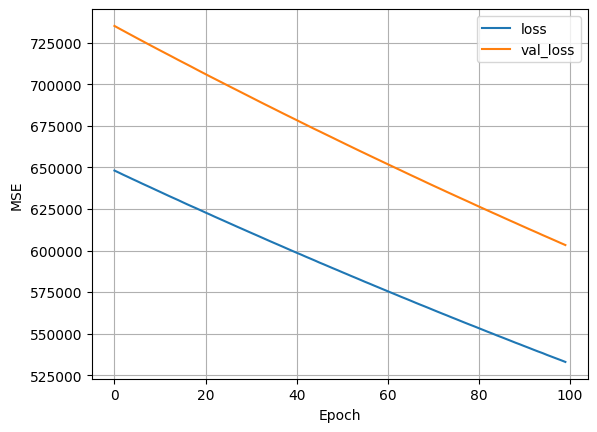

In [68]:
plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


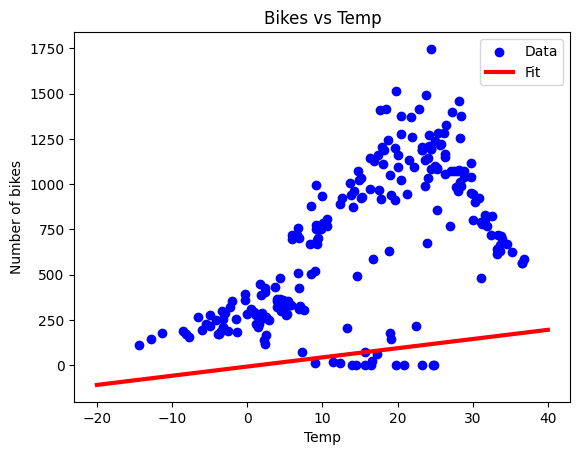

In [69]:
plt.scatter(X_train_temp, Y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_temp.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)

plt.title('Bikes vs Temp')
plt.xlabel('Temp')
plt.ylabel('Number of bikes')
plt.legend()
plt.show()

In [74]:
all_nn_reg=tf.keras.layers.Normalization(input_shape=(len(X_train[0]),),axis=-1)
all_nn_reg.adapt(X_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
nn_reg = tf.keras.Sequential([
    all_nn_reg,
    tf.keras.layers.Dense(20, activation='relu'),  # More units
    tf.keras.layers.Dense(10, activation='relu'),  # Additional layer
    tf.keras.layers.Dense(1)])

In [86]:
nn_reg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Even lower learning rate
    loss="mean_squared_error"
)

In [79]:
history_all = nn_reg.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=300,  # More epochs
    verbose=0
)

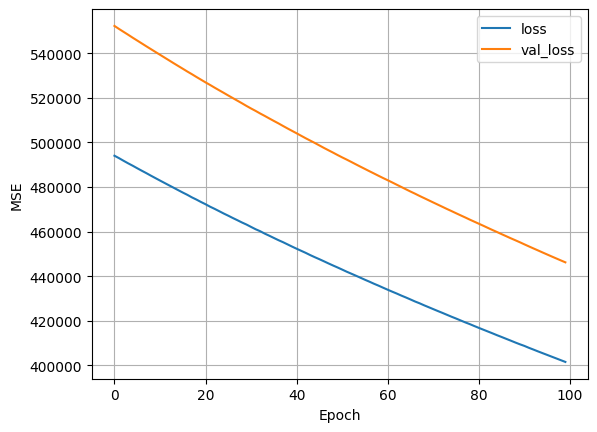

In [80]:
plot_history(history_all)